# Analysis of Jet Stream Impact on Commercial Flights

Jet streams are fast flowing, narrow, meandering air currents in the atmospheres of some planets, including Earth. The strongest jet streams are the polar and sub-tropical ones.

Use of the jet stream by commercial planes began on 18 November 1952 as it can save both travel time and fuel.

https://en.wikipedia.org/wiki/Jet_stream


Our claim is that the Jet Streams can and do affect the fuel consumption and average cruising speed of commercial flights.

In [1]:
import sqlite3 # Package for running sql queries.
import pandas as pd # Pandas.
import time, datetime, os # Packages for dealing with date and working directory.
import numpy as np # Numpy.
import scipy as sp # Scipy for statistical tests.
import matplotlib.pyplot as plt # Package for plotting.
import seaborn as sns # Package for advanced plotting.
import statsmodels.api as sm # Linear Regression Model package.
from sklearn.cluster import KMeans # KMeans.
# Importing needed packages.

os.chdir("\\") # Working Directory. Needs changing!

## Importing Data
### Importing Airports Database from .db file:

In [2]:
conn = sqlite3.connect("flights.db") # NEEDS CHANGING FROM PC TO PC!!

cursor = conn.cursor() # Initialize the cursor for the SQLite.

query = "select * from airports" # Query to gather all the airports table.

airports = cursor.execute(query).fetchall()

ap = pd.DataFrame(data=airports)
ap.columns = ["code", "code_icao", "name", "city", "country_code", "lat", "lon"]
# Here we take all of the attributes from the airports table and store into a DataFrame
# and give appropriate names to the columns.
ap.head()

,code,code_icao,name,city,country_code,lat,lon
0,AAE,DABB,Annaba Rabah Bitat Airport,Annaba,DZ,36.822220,7.809167
1,AAH,EDKA,Aachen Merzbruck Airport,Aachen,DE,50.823051,6.186111
2,AAL,EKYT,Aalborg Airport,Aalborg,DK,57.092781,9.849164
3,ABE,KABE,Allentown Lehigh Valley International Airport,Allentown,US,40.652302,-75.440399
4,ABJ,DIAP,Abidjan Port Bouet Airport,Abidjan,CI,5.261386,-3.926290


### Importing from the .txt files

##### Flights with distance, avg. speed, etc. considering only after 3km traveled and taking off and until 3km before landing (18-11-1_18-11-23):

In [3]:
aux = np.loadtxt("distlines.txt", dtype=str, delimiter="	")

d = {
    "ap_orig" : [row[0] for row in aux], "dir_orig" : list(map(int, [row[1] for row in aux])),
    "ap_dest" : [row[2] for row in aux], "dir_dest" : [row[3] for row in aux],
    "dist" : list(map(float, [row[4] for row in aux])), "avg_speed" : list(map(float, [row[5] for row in aux])),
    "time" : list(map(float, [row[6] for row in aux])), "plane_reg" : [row[7] for row in aux],
    "plane_model" : [row[8] for row in aux], "time_orig" : [row[9] for row in aux],
    "time_dest" : [row[10] for row in aux], "hex_id" : [row[11] for row in aux]
    }


fl = pd.DataFrame(d)

del aux, d

fl.head()

,ap_orig,dir_orig,ap_dest,dir_dest,dist,avg_speed,time,plane_reg,plane_model,time_orig,time_dest,hex_id
0,SEA,180,IAD,,3392.009,975.494,3.5,N17128,Boeing 757-224ER,2018-10-31 20:30:23,2018-10-31 23:59:01,/1e680781
1,LIS,206,REC,,2271.824,874.713,2.6,9H-SOL,Airbus A340-313,2018-10-31 20:30:22,2018-10-31 23:06:12,/1e6812e7
2,EWR,207,LIM,,3691.428,853.839,4.3,N33132,Boeing 757-224,2018-10-31 19:40:08,2018-10-31 23:59:32,/1e67e78f
3,ADD,74,FRA,,1484.959,800.397,1.9,D-AIGZ,Airbus A340-313,2018-10-31 22:08:28,2018-10-31 23:59:47,/1e6822d5
4,JNB,15,DXB,,2658.146,920.039,2.9,A6-EGU,Boeing 777-31H(ER),2018-10-31 21:05:21,2018-10-31 23:58:42,/1e681a96


### Importing data about plane models from the .csv. Source: http://www.portalbrasil.net/aviacao_comparativo.htm:

In [4]:
pl = pd.read_csv("planes.csv")

pl.head()

,model,passengers_turbines,crew,start_prod,consumption,autonomy,value,value_leasing
0,Tupolev TU-104,72 - 2A,6,Feb-56,5.1,Curta,"2,280",20
1,De Havilland Comet 2,46 - 4A,6,Jun-56,5.5,Média,"3,702",33.6
2,De Havilland Comet 4,82 - 4A,8,Oct-57,7,Longa,"6,600","60,0"
3,Boeing 707-120,110 - 4A,8,Oct-58,7.3,Longa,6.881,62
4,Fokker F-27,44 - 2A,4,Dec-58,7.20 (Th),Curta,"2,580",23


## Treating Data
### pl (plane models) table
#### Turning variable consumption into float:

In [5]:
aux = pd.Series(np.repeat(0.0, pl.consumption.size)) # Auxiliar variable

for i in range(0, pl.consumption.size):
    if (pl.consumption[i].split(" ")[0] == "s/dados"):  # "s/dados" means missing value.
        aux[i] = np.nan
        
    else:
        aux[i] = pl.consumption[i].split(" ")[0] # Takes only the first part of the string until first space.

pl.consumption = aux

del aux

pl.head()

,model,passengers_turbines,crew,start_prod,consumption,autonomy,value,value_leasing
0,Tupolev TU-104,72 - 2A,6,Feb-56,5.1,Curta,"2,280",20
1,De Havilland Comet 2,46 - 4A,6,Jun-56,5.5,Média,"3,702",33.6
2,De Havilland Comet 4,82 - 4A,8,Oct-57,7.0,Longa,"6,600","60,0"
3,Boeing 707-120,110 - 4A,8,Oct-58,7.3,Longa,6.881,62
4,Fokker F-27,44 - 2A,4,Dec-58,7.2,Curta,"2,580",23


#### Splitting column passengers_turbines intro two separate columns and turning passengers from string into int:

In [6]:
aux = pd.Series(np.repeat(0, pl.passengers_turbines.size)) # Auxiliar variables
aux2 = pd.Series(np.repeat(" ", pl.passengers_turbines.size))

for i in range(0, pl.passengers_turbines.size):
    aux[i] = int(pl.passengers_turbines[i].split(" ")[0]) # Splits the column passengers_turbines into 2 columns: passengers and
    aux2[i] = pl.passengers_turbines[i].split(" ")[2]     # turbines.

pl["passengers"] = aux
pl["turbines"] = aux2

del aux, aux2
pl.drop(columns="passengers_turbines", inplace=True)

pl.head()

,model,crew,start_prod,consumption,autonomy,value,value_leasing,passengers,turbines
0,Tupolev TU-104,6,Feb-56,5.1,Curta,"2,280",20,72,2A
1,De Havilland Comet 2,6,Jun-56,5.5,Média,"3,702",33.6,46,4A
2,De Havilland Comet 4,8,Oct-57,7.0,Longa,"6,600","60,0",82,4A
3,Boeing 707-120,8,Oct-58,7.3,Longa,6.881,62,110,4A
4,Fokker F-27,4,Dec-58,7.2,Curta,"2,580",23,44,2A


### fl (flights) table
#### Removing undesired rows:

We are removing the rows without airport in either destination or origin column. We also are removing flights that are shorter than 1000 kilometer in cruising speed.

In [7]:

m_dest = fl[fl.ap_dest == ""]["ap_orig"].count() # Number of rows removed.
fl = fl[fl.ap_dest!=""] # Removing rows without airport of destination.

m_orig = fl[fl.ap_orig == ""]["ap_orig"].count() # Number of rows removed.
fl = fl[fl.ap_orig!=""] # Removing rows without airport of origin.

m_dist = fl[fl.dist<999]["ap_orig"].count() # Number of rows removed.
fl = fl[fl.dist>999] # Removing flights with a lesser distance than 1000km.

fl.reset_index(inplace=True, drop=True) # Resets index.

### Creating column orientation:
For this we used an if operator to, first, check if there are matches for both the origin and destination airports in the ap table.

Then we took the latitude and longitude of both airports and compared the absolute difference in latitude and longitude between them. If the longitude difference is bigger, then the orientation is E or W. It will be N or S otherwise.

Inside the if and else we create another comparison to check if it is indeed E or W (and N or S).

When this is finished we take the auxiliar variable holding all these orientations and add as the "orientation" column to the fl table.

In short, this will give each flight the main cardinal direction the plane will be flying towards.

In [8]:
aux = pd.Series(np.repeat("-", fl.ap_orig.size)) # Auxiliar series.

for i in range(0, fl.ap_orig.size):
    if((fl.ap_orig[i] in list(ap.code)) & (fl.ap_dest[i] in list(ap.code))):
    
        lon_o = ap[ap.code==fl.ap_orig[i]].lon.iloc[0]
        lon_d = ap[ap.code==fl.ap_dest[i]].lon.iloc[0]
    
        lat_o = ap[ap.code==fl.ap_orig[i]].lat.iloc[0]
        lat_d = ap[ap.code==fl.ap_dest[i]].lat.iloc[0]
    
        if(abs(lon_d-lon_o) > abs(lat_d-lat_o)):
            if(ap[ap.code==fl.ap_dest[i]].lon.iloc[0] > ap[ap.code==fl.ap_orig[i]].lon.iloc[0]): # Compares Longitude.
                aux[i] = "E"
            else:
                aux[i] = "W"
            
        else:
            if(ap[ap.code==fl.ap_dest[i]].lat.iloc[0] > ap[ap.code==fl.ap_orig[i]].lat.iloc[0]): # Compares Longitude.
                aux[i] = "N"
            else:
                aux[i] = "S"
        

fl["orientation"] = aux

del aux

fl.head()

,ap_orig,dir_orig,ap_dest,dir_dest,dist,avg_speed,time,plane_reg,plane_model,time_orig,time_dest,hex_id,orientation
0,SEA,180,IAD,,3392.009,975.494,3.5,N17128,Boeing 757-224ER,2018-10-31 20:30:23,2018-10-31 23:59:01,/1e680781,E
1,LIS,206,REC,,2271.824,874.713,2.6,9H-SOL,Airbus A340-313,2018-10-31 20:30:22,2018-10-31 23:06:12,/1e6812e7,S
2,EWR,207,LIM,,3691.428,853.839,4.3,N33132,Boeing 757-224,2018-10-31 19:40:08,2018-10-31 23:59:32,/1e67e78f,S
3,ADD,74,FRA,,1484.959,800.397,1.9,D-AIGZ,Airbus A340-313,2018-10-31 22:08:28,2018-10-31 23:59:47,/1e6822d5,N
4,JNB,15,DXB,,2658.146,920.039,2.9,A6-EGU,Boeing 777-31H(ER),2018-10-31 21:05:21,2018-10-31 23:58:42,/1e681a96,N


We need to, then, remove the rows that remained with "-" in the orientation column, because that means that either the destination or origin airport were not in the ap table.

In [9]:
m_orient = fl[fl.orientation=="-"]["ap_orig"].count() # Number of rows removed.
fl = fl[fl.orientation!="-"] # Removes rows with airports not present in the ap table.

fl.reset_index(inplace=True, drop=True) # Resets index.

As we can see in the piechart below, the group [E,W] hold the majority of flights. This happens because this is our main group of interest, while the [N,S] groups is only used as a sort of control group.

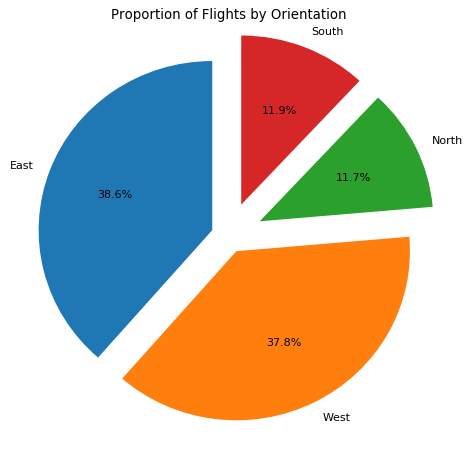

In [79]:
d = [fl[fl.orientation=="E"]["orientation"].count(), fl[fl.orientation=="W"]["orientation"].count(), 
     fl[fl.orientation=="N"]["orientation"].count(), fl[fl.orientation=="S"]["orientation"].count()]
explode = (0.1, 0.1, 0.2, 0.2)
labels = ['East', 'West', 'North', 'South']

plt.figure(num=None, figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.pie(d, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90)


plt.title('Proportion of Flights by Orientation')
plt.show()

### Pie Plot of the Percentage of Removed Rows from the Dataset

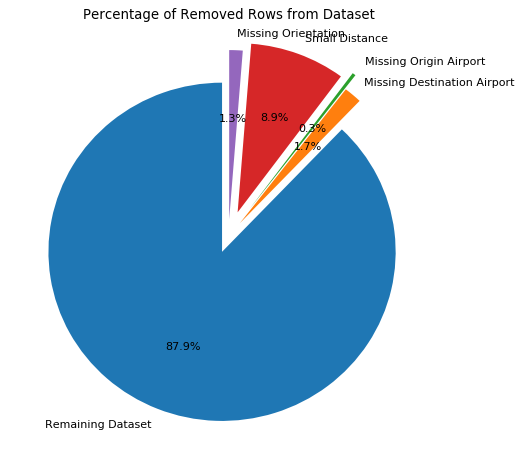

In [10]:
d = [fl.shape[0], m_dest, m_orig, m_dist, m_orient]
explode = (0.1, 0.1, 0.2, 0.15, 0.1)
labels = ['Remaining Dataset', 'Missing Destination Airport', 'Missing Origin Airport', 'Small Distance', "Missing Orientation"]

plt.figure(num=None, figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.pie(d, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90)


plt.title('Percentage of Removed Rows from Dataset')
plt.show()

### Extracting the consumption and number of passengers of planes from the pl table into the fl table:
In order to achieve this, we need to find matches in names of models from the fl and pl tables.

In this for loop we try to find a match of the model name coming from the fl table cut until the first digit after the "-" symbol (i.e. 'Boeing 757-224ER' into 'Boeing 757-2'), which is usually enough to find a soft match.

We use a flag variable to indicate there is an "ER" in the model name, which will decide inside each iteration of the external loop if there is a need to look for an "ER" in the model name when looking through pl table.

If, in the end of the inner loop (at the end of searching through pl table), no match is found we try again to look for a softer match removing the "-" and last digit of the string used to compare the model names.



In [11]:
aux1 = pd.Series(np.repeat(0.0, fl.shape[0])) # Auxiliar series that will hold the values of consumption and passengers.
aux2 = pd.Series(np.repeat(0, fl.shape[0]))


for i in range(0, fl.shape[0]): # Goes through the fl rows.
    
    er = 0                # Setting flag variable indicating there is an "ER" in the name of the plane model. Resets each
                          # iteration of external loop (index i).
            
    z = fl.plane_model[i] # Storing the model name from fl in variable z.
    
    y = z.find("-") # Finds where is the "-" in the model name.
    x = z[0:y+2]    # Takes everything until one nuber after the "-", as this is generally the important part of the string
                    # to find a soft match in pl table.
    
    if (z.find("ER") != -1): er = 1 # Checks if there is "ER" in the model name. If there is, sets flag er to 1. Its 0 otherwise.
    
    c = 0 # Setting another flag variable. This is to indicate a match has been found. Resets each iteration of
          # external loop (i index).
        
    if (er==1): # If there was an "ER" in the model name.
        for j in range(0, pl.shape[0]): # Goes through all the pl table rows.
            if((pl.model[j].find(x) != -1) & (pl.model[j].find("ER") != -1)): # If there is a match AND there is an "ER".
                aux1[i] = pl.consumption[j] # Takes consumption from this model into aux1.
                aux2[i] = pl.passengers[j]  # Takes number of passsangers of this model into aux2.
                c = 1 # Sets flag to 1, that is, match has been found
                break # Breaks out of inner loop
                
            if ((j==pl.shape[0]-1) & (c==0)):
                for l in range(0, pl.shape[0]): # Goes through all the pl table rows.
                    if(pl.model[l].find(x) != -1): # If there is a match in model names.
                        aux1[i] = pl.consumption[l] # Takes consumption from this model into aux1.
                        aux2[i] = pl.passengers[l]  # Takes number of passsangers of this model into aux2.
                        break # Breaks out of inner loop


    else: # If there isnt an "ER" in the model name.
        for j in range(0, pl.shape[0]): # Goes through all the pl table rows.
            if(pl.model[j].find(x) != -1): # If there is a match in model names.
                aux1[i] = pl.consumption[j] # Takes consumption from this model into aux1.
                aux2[i] = pl.passengers[j]  # Takes number of passsangers of this model into aux2.
                c = 1
                break # Breaks out of inner loop
                
            if ((j==pl.shape[0]-1) & (c==0)): # If this is the last inner loop (j) iteration and no match has been found.
                x = x[:-2] # Try to find a looser match. Takes the "-" and first digit after it out of x.
                for l in range(0, pl.shape[0]): # Goes through all the pl table rows.
                    if(pl.model[l].find(x) != -1): # If there is a match in model names.
                        aux1[i] = pl.consumption[l] # Takes consumption from this model into aux1.
                        aux2[i] = pl.passengers[l]  # Takes number of passsangers of this model into aux2.
                        break # Breaks out of inner loop

                        
    

fl["consumption"] = aux1  # New column "consumption" receives aux1.
fl["passengers"] = aux2   # New column "paassengers" receives aux2.

del aux1, aux2 # Deletes variables not needed anymore.

fl.head()

,ap_orig,dir_orig,ap_dest,dir_dest,dist,avg_speed,time,plane_reg,plane_model,time_orig,time_dest,hex_id,orientation,consumption,passengers
0,SEA,180,IAD,,3392.009,975.494,3.5,N17128,Boeing 757-224ER,2018-10-31 20:30:23,2018-10-31 23:59:01,/1e680781,E,4.6,186
1,LIS,206,REC,,2271.824,874.713,2.6,9H-SOL,Airbus A340-313,2018-10-31 20:30:22,2018-10-31 23:06:12,/1e6812e7,S,8.4,286
2,EWR,207,LIM,,3691.428,853.839,4.3,N33132,Boeing 757-224,2018-10-31 19:40:08,2018-10-31 23:59:32,/1e67e78f,S,4.6,186
3,ADD,74,FRA,,1484.959,800.397,1.9,D-AIGZ,Airbus A340-313,2018-10-31 22:08:28,2018-10-31 23:59:47,/1e6822d5,N,8.4,286
4,JNB,15,DXB,,2658.146,920.039,2.9,A6-EGU,Boeing 777-31H(ER),2018-10-31 21:05:21,2018-10-31 23:58:42,/1e681a96,N,9.1,352


### Creating the fuel_passenger column:
We now will create the fuel_passenger column, which is the total consumption of fuel of the flight divided by the maximum number of passengers of the plane used.

We multiply the consumption (liters/hour) column by the time (hours) to get the total consumption of fuel o the flight (liters). Then, we divide this by the passengers column, getting Total Fuel used by Passenger (in liters).

In [12]:
fl["fuel_passenger"] = (fl.time*fl.consumption)/fl.passengers

fl.head()

,ap_orig,dir_orig,ap_dest,dir_dest,dist,avg_speed,time,plane_reg,plane_model,time_orig,time_dest,hex_id,orientation,consumption,passengers,fuel_passenger
0,SEA,180,IAD,,3392.009,975.494,3.5,N17128,Boeing 757-224ER,2018-10-31 20:30:23,2018-10-31 23:59:01,/1e680781,E,4.6,186,0.086559
1,LIS,206,REC,,2271.824,874.713,2.6,9H-SOL,Airbus A340-313,2018-10-31 20:30:22,2018-10-31 23:06:12,/1e6812e7,S,8.4,286,0.076364
2,EWR,207,LIM,,3691.428,853.839,4.3,N33132,Boeing 757-224,2018-10-31 19:40:08,2018-10-31 23:59:32,/1e67e78f,S,4.6,186,0.106344
3,ADD,74,FRA,,1484.959,800.397,1.9,D-AIGZ,Airbus A340-313,2018-10-31 22:08:28,2018-10-31 23:59:47,/1e6822d5,N,8.4,286,0.055804
4,JNB,15,DXB,,2658.146,920.039,2.9,A6-EGU,Boeing 777-31H(ER),2018-10-31 21:05:21,2018-10-31 23:58:42,/1e681a96,N,9.1,352,0.074972


##  Analysis of Data

### Checking the Distribution of Plane Models in Orientation Groups:

Before we start the analysis we should check if there is any great difference in the distribution of plane models in each group of cardinal directions ([N,S], [E,W]), as this could bias the results of our analysis.

In [13]:
pd.crosstab(fl.plane_model, fl.orientation)

orientation,E,N,S,W
plane_model,,,,
Airbus A319-112,1,0,1,1
Airbus A320-214,42,1,1,39
Airbus A320-232,31,3,3,29
Airbus A330-202,7,6,7,10
Airbus A330-223,5,0,0,4
Airbus A330-302,30,0,1,27
Airbus A330-303,11,14,15,11
Airbus A330-323,41,0,0,41
Airbus A330-343,41,16,14,34


We can see that E and W show, in general, similar distribution of plane models, while S and N also do have similar distribution of models. So this should not interfere in results in average speed and fuel consumption.

### Kolmogorov-Smirnov Test for 2 Independent Samples:

Let us perform a Kolmogorov-Smirnov statistic on 2 samples.This is a two-sided test for the null hypothesis that 2 independent samples are drawn from the same continuous distribution.

In [61]:
d_E = pd.crosstab(fl.plane_model, fl.orientation).iloc[:,0]
d_N = pd.crosstab(fl.plane_model, fl.orientation).iloc[:,1]
d_S = pd.crosstab(fl.plane_model, fl.orientation).iloc[:,2]
d_W = pd.crosstab(fl.plane_model, fl.orientation).iloc[:,3]

sp.stats.ks_2samp(d_E, d_W) # East and West

Ks_2sampResult(statistic=0.0625, pvalue=0.9999680857929982)

In [62]:
sp.stats.ks_2samp(d_N, d_S) # North and South

Ks_2sampResult(statistic=0.04166666666666674, pvalue=0.9999999999914052)

In [63]:
sp.stats.ks_2samp(d_E, d_N) # East and North

Ks_2sampResult(statistic=0.4375, pvalue=0.00011899444571314337)

In [64]:
sp.stats.ks_2samp(d_W, d_S) # West and South

Ks_2sampResult(statistic=0.4375, pvalue=0.00011899444571314337)

The test for the groups [E,W] and [N,S] show a really high p_value (0.99), which indicates that the probability that the null hypothesis of these groups having the same distribution is almost zero, confirming our suspicion.

Just for curiositys sake, we can check the really low p-values for the groups [E,N] and [W,S] indicating these groups are very likely to be drawn from different distributions.

In short, the plane models should NOT interfere in our analysis results.

### Boxplots of Fuel Spent by Passenger of Flights:

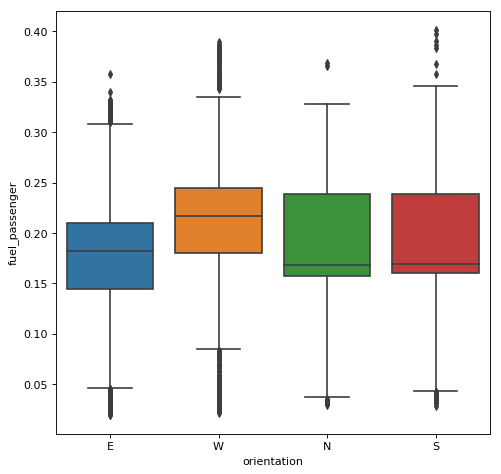

In [65]:
plt.figure(num=None, figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')

sns.boxplot(x ="orientation", y="fuel_passenger", orient="v", data = fl, order=["E", "W", "N", "S"])
plt.show()

We can see the boxplot of flights going East is slightly lower than the others, while the flights going West seem to have a median higher significantly higher than the others.

### Boxplots of Average Cruising Speed:

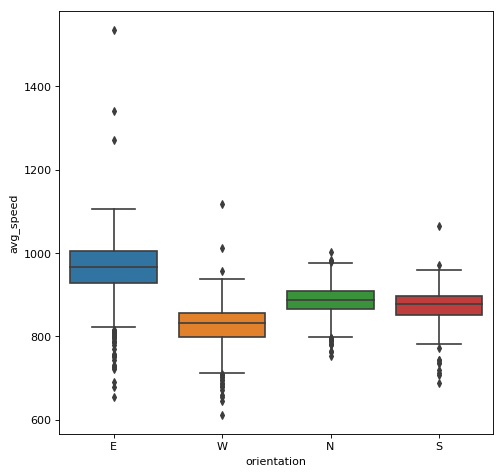

In [66]:
plt.figure(num=None, figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
sns.boxplot(x ="orientation", y="avg_speed", orient="v", data = fl, order=["E", "W", "N", "S"])
plt.show()

Perhaps this is the most informative plot about the impact of Jet Streams on commercial flights. While the flights going South and North do not show great difference, the boxplot of flights going East is significantly higher in terms of average cruising speed.

### Scatterplots

#### Scatterplot of Fuel Spent by each Passenger by Average Cruising Speed (Color grouped by Orientation):

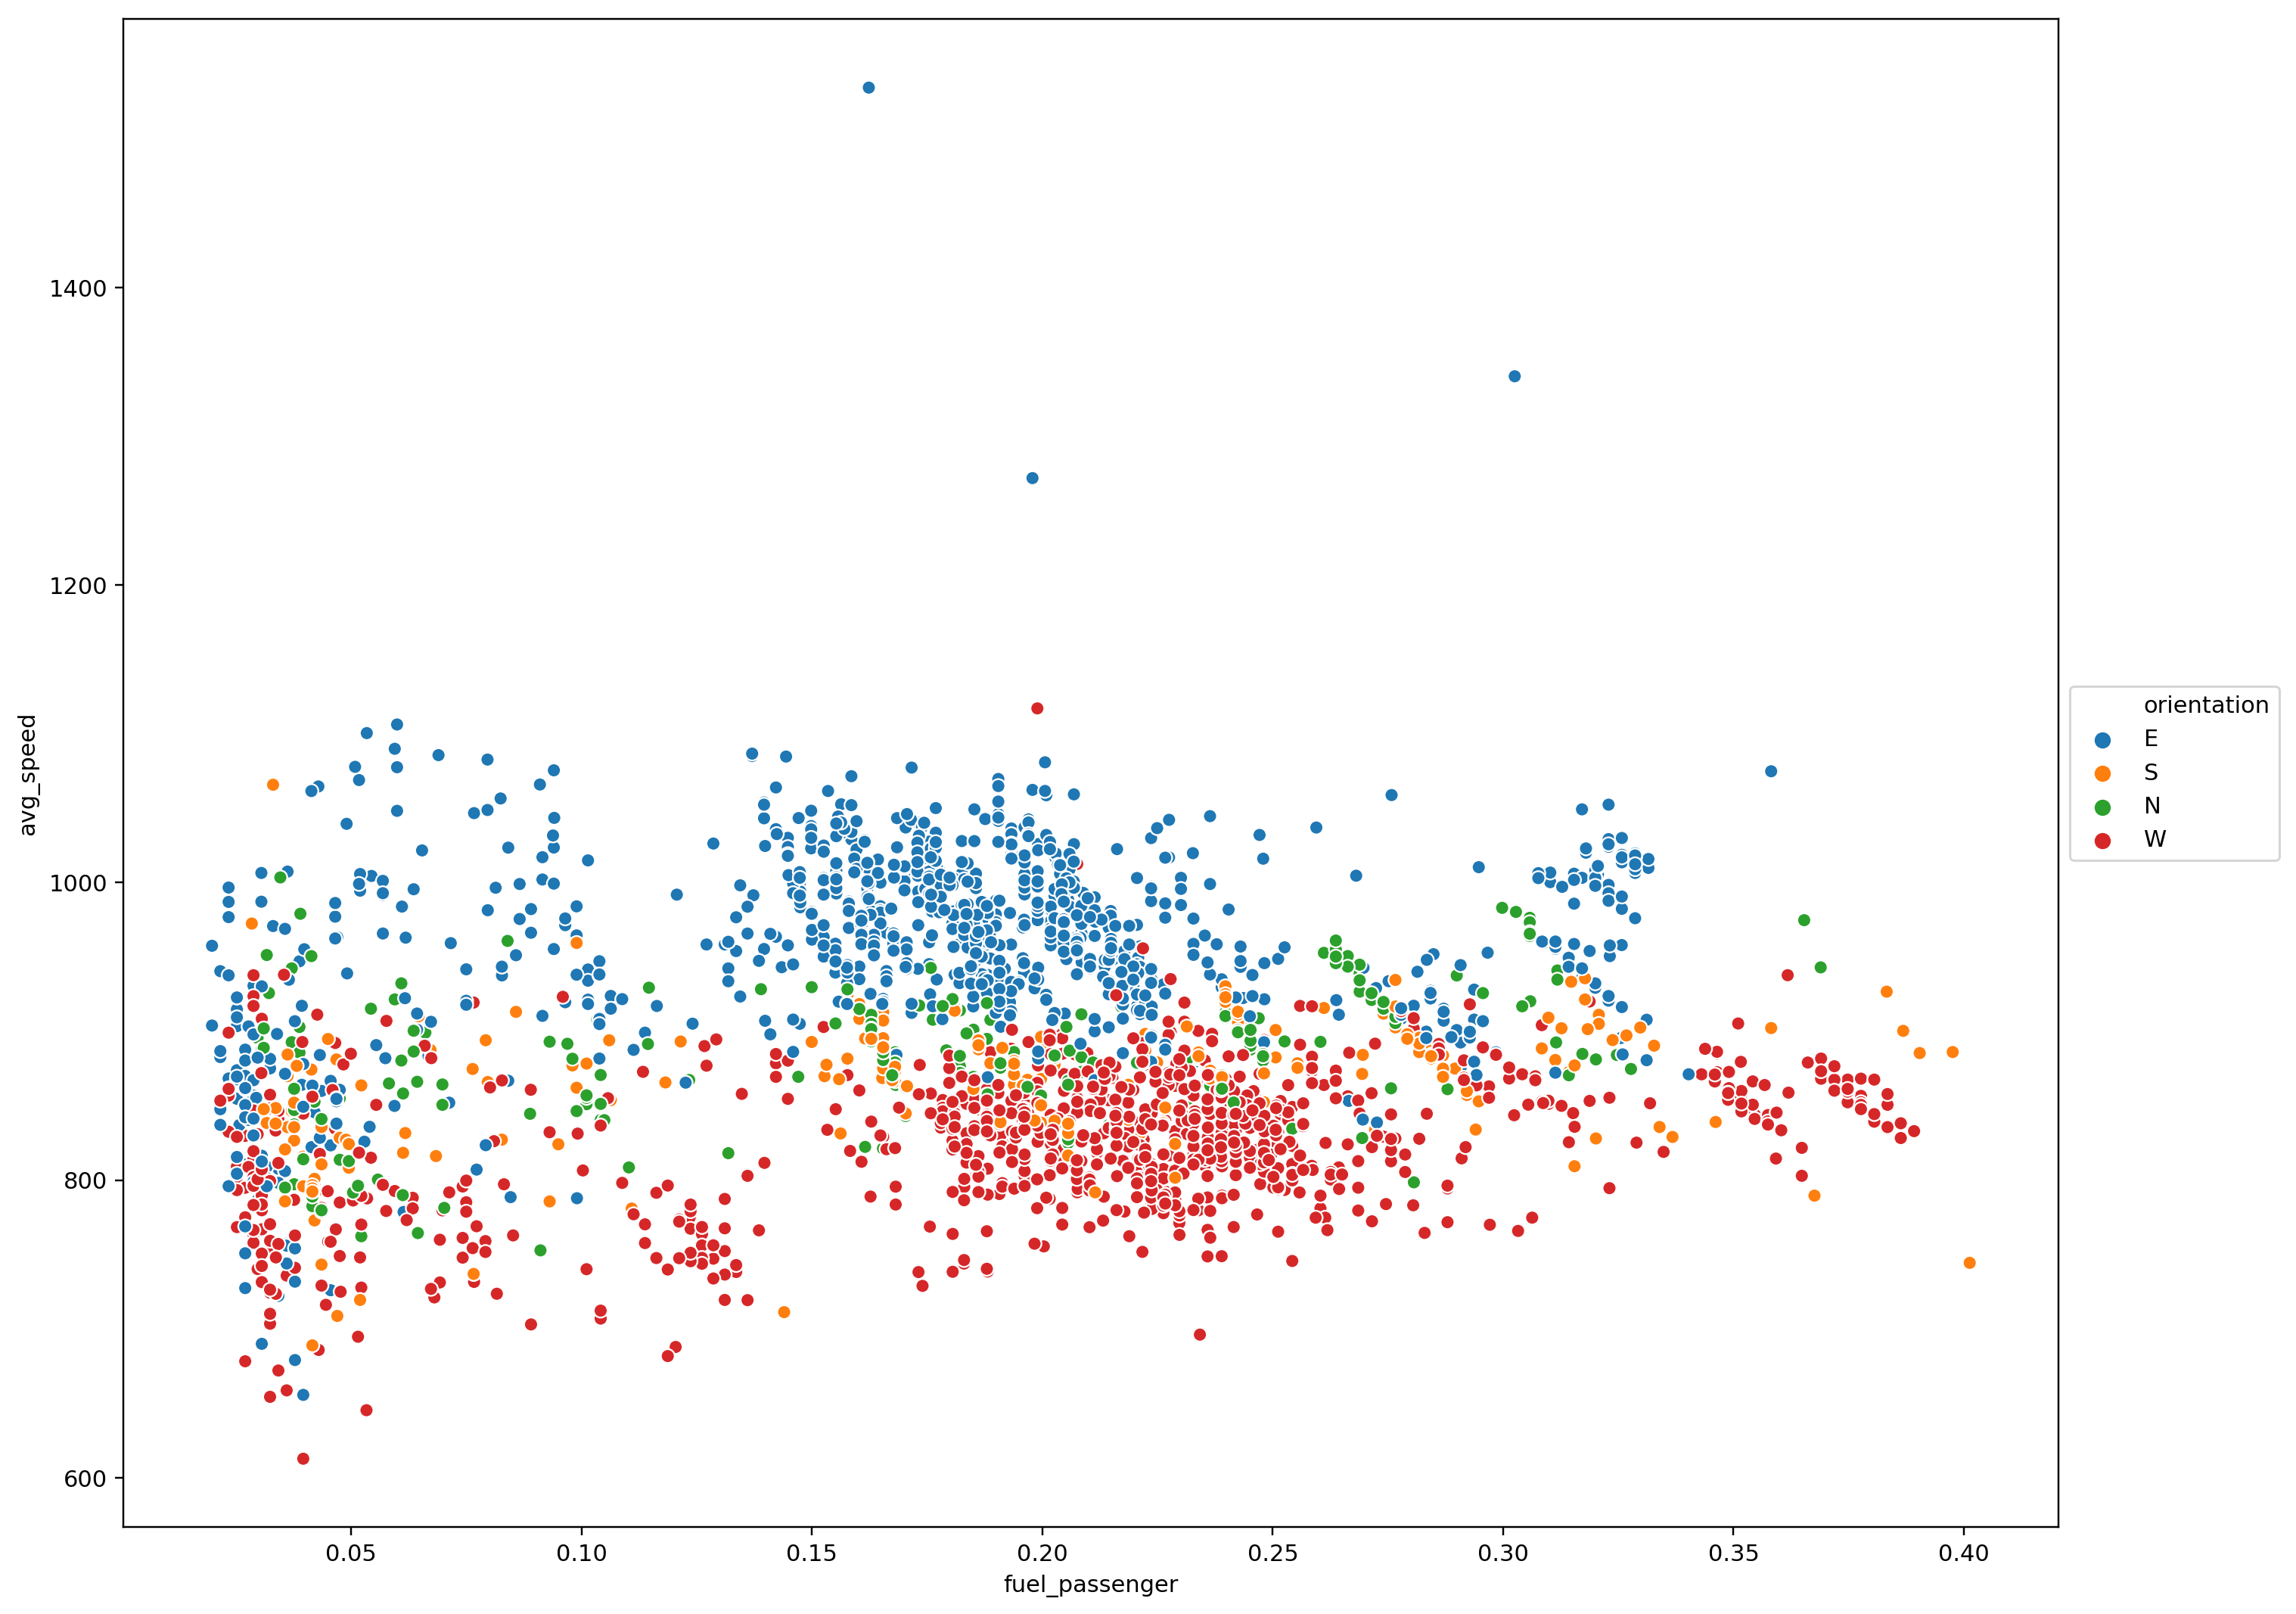

In [20]:
plt.figure(num=None, figsize=(15, 12), dpi=220, facecolor='w', edgecolor='k')

sns.scatterplot(x="fuel_passenger", y="avg_speed", hue="orientation", data=fl)


plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)) # Putting the legend box to the right side of the plot.

plt.show()

It is possible to see some patterns in the distributions of the groups of flights going each cardinal direction. Most prominent is that the avg_speed of the E group is significantly higher than the others, while the W group seems to be on the bottom of this axis.

We should separate the [E,W] and [N,S] groups to better understand their behaviour.

First a divide in the fl table is needed:

In [21]:
fl1 = fl[((fl.orientation == "E") | (fl.orientation == "W"))] # Only E and W flights.

fl2 = fl[((fl.orientation == "N") | (fl.orientation == "S"))] # Only N and S flights.

#### Scatterplot of Fuel Spent by each Passenger by Average Cruising Speed (E and W):

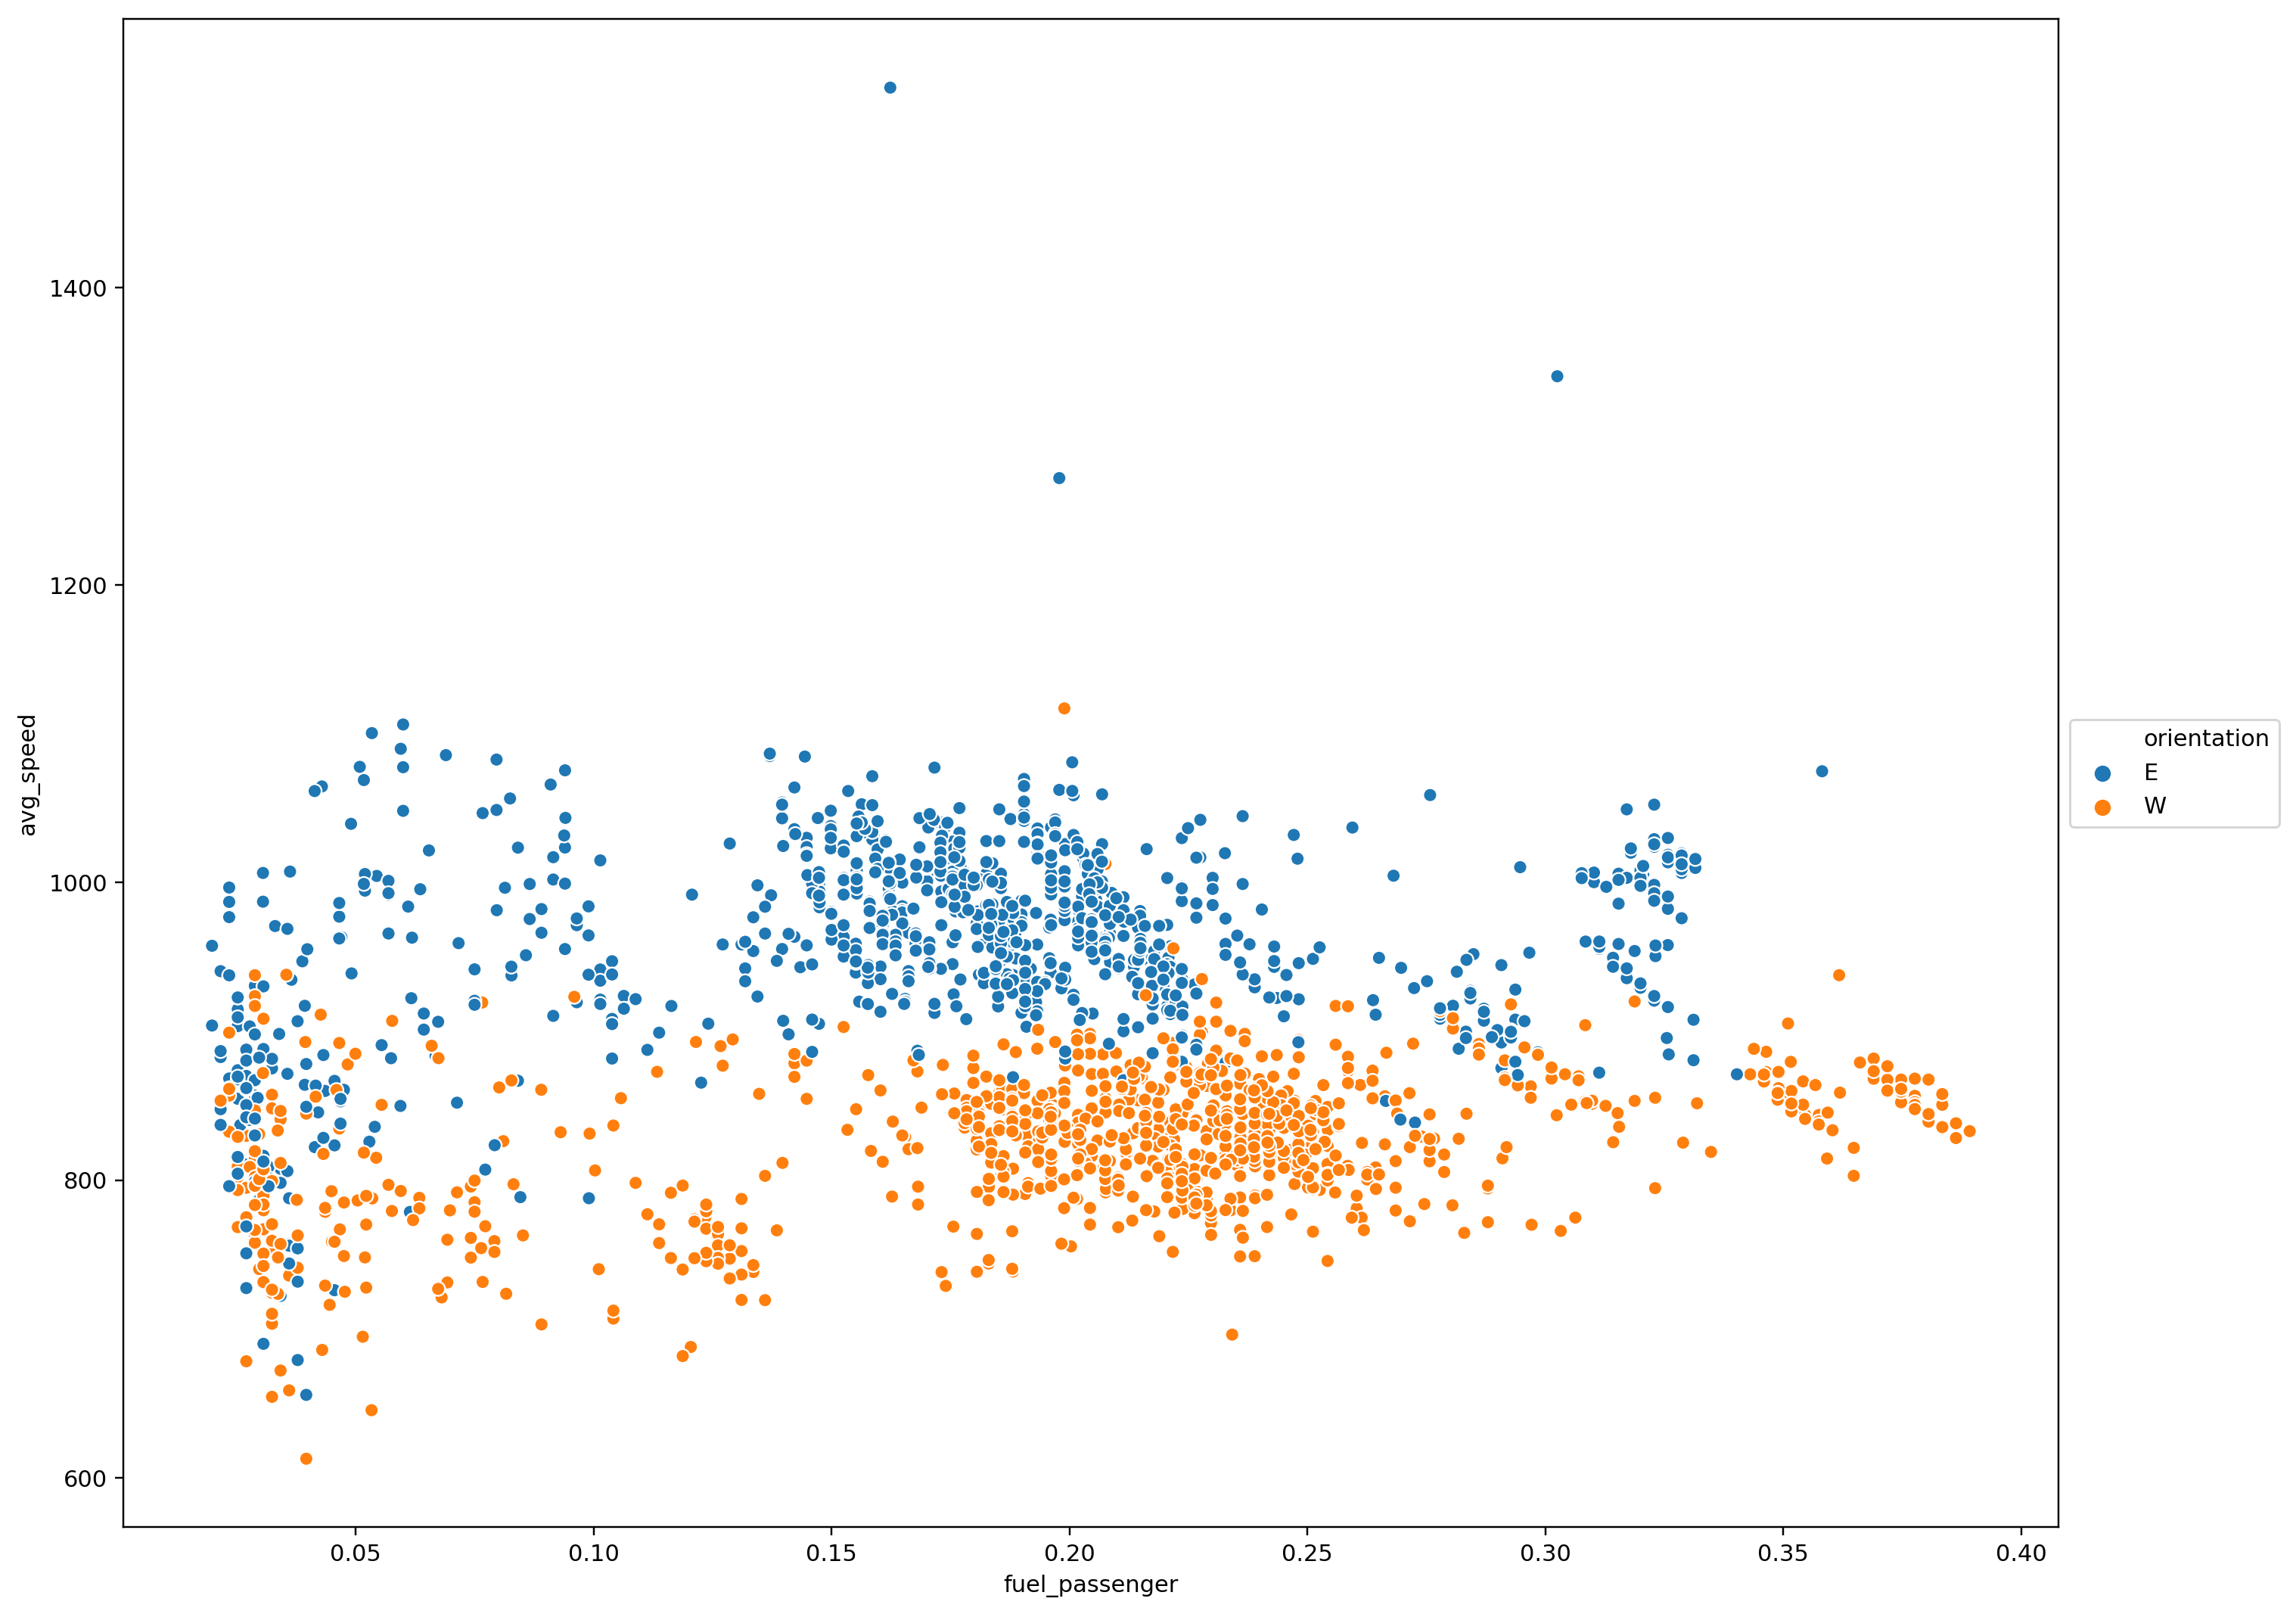

In [22]:
plt.figure(num=None, figsize=(15, 12), dpi=220, facecolor='w', edgecolor='k')

sns.scatterplot(x="fuel_passenger", y="avg_speed", hue="orientation", data=fl1)


plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)) # Putting the legend box to the right side of the plot.

plt.show()

Here we can see better the difference in average cruising speed of these two groups. The distribution of fuel spent by passenger of the W group also extends a little longer on the higher tail, meaning these flights should spend a little more fuel than the ones going East.

#### Scatterplot of Fuel Spent by each Passenger by Average Cruising Speed (N and S):

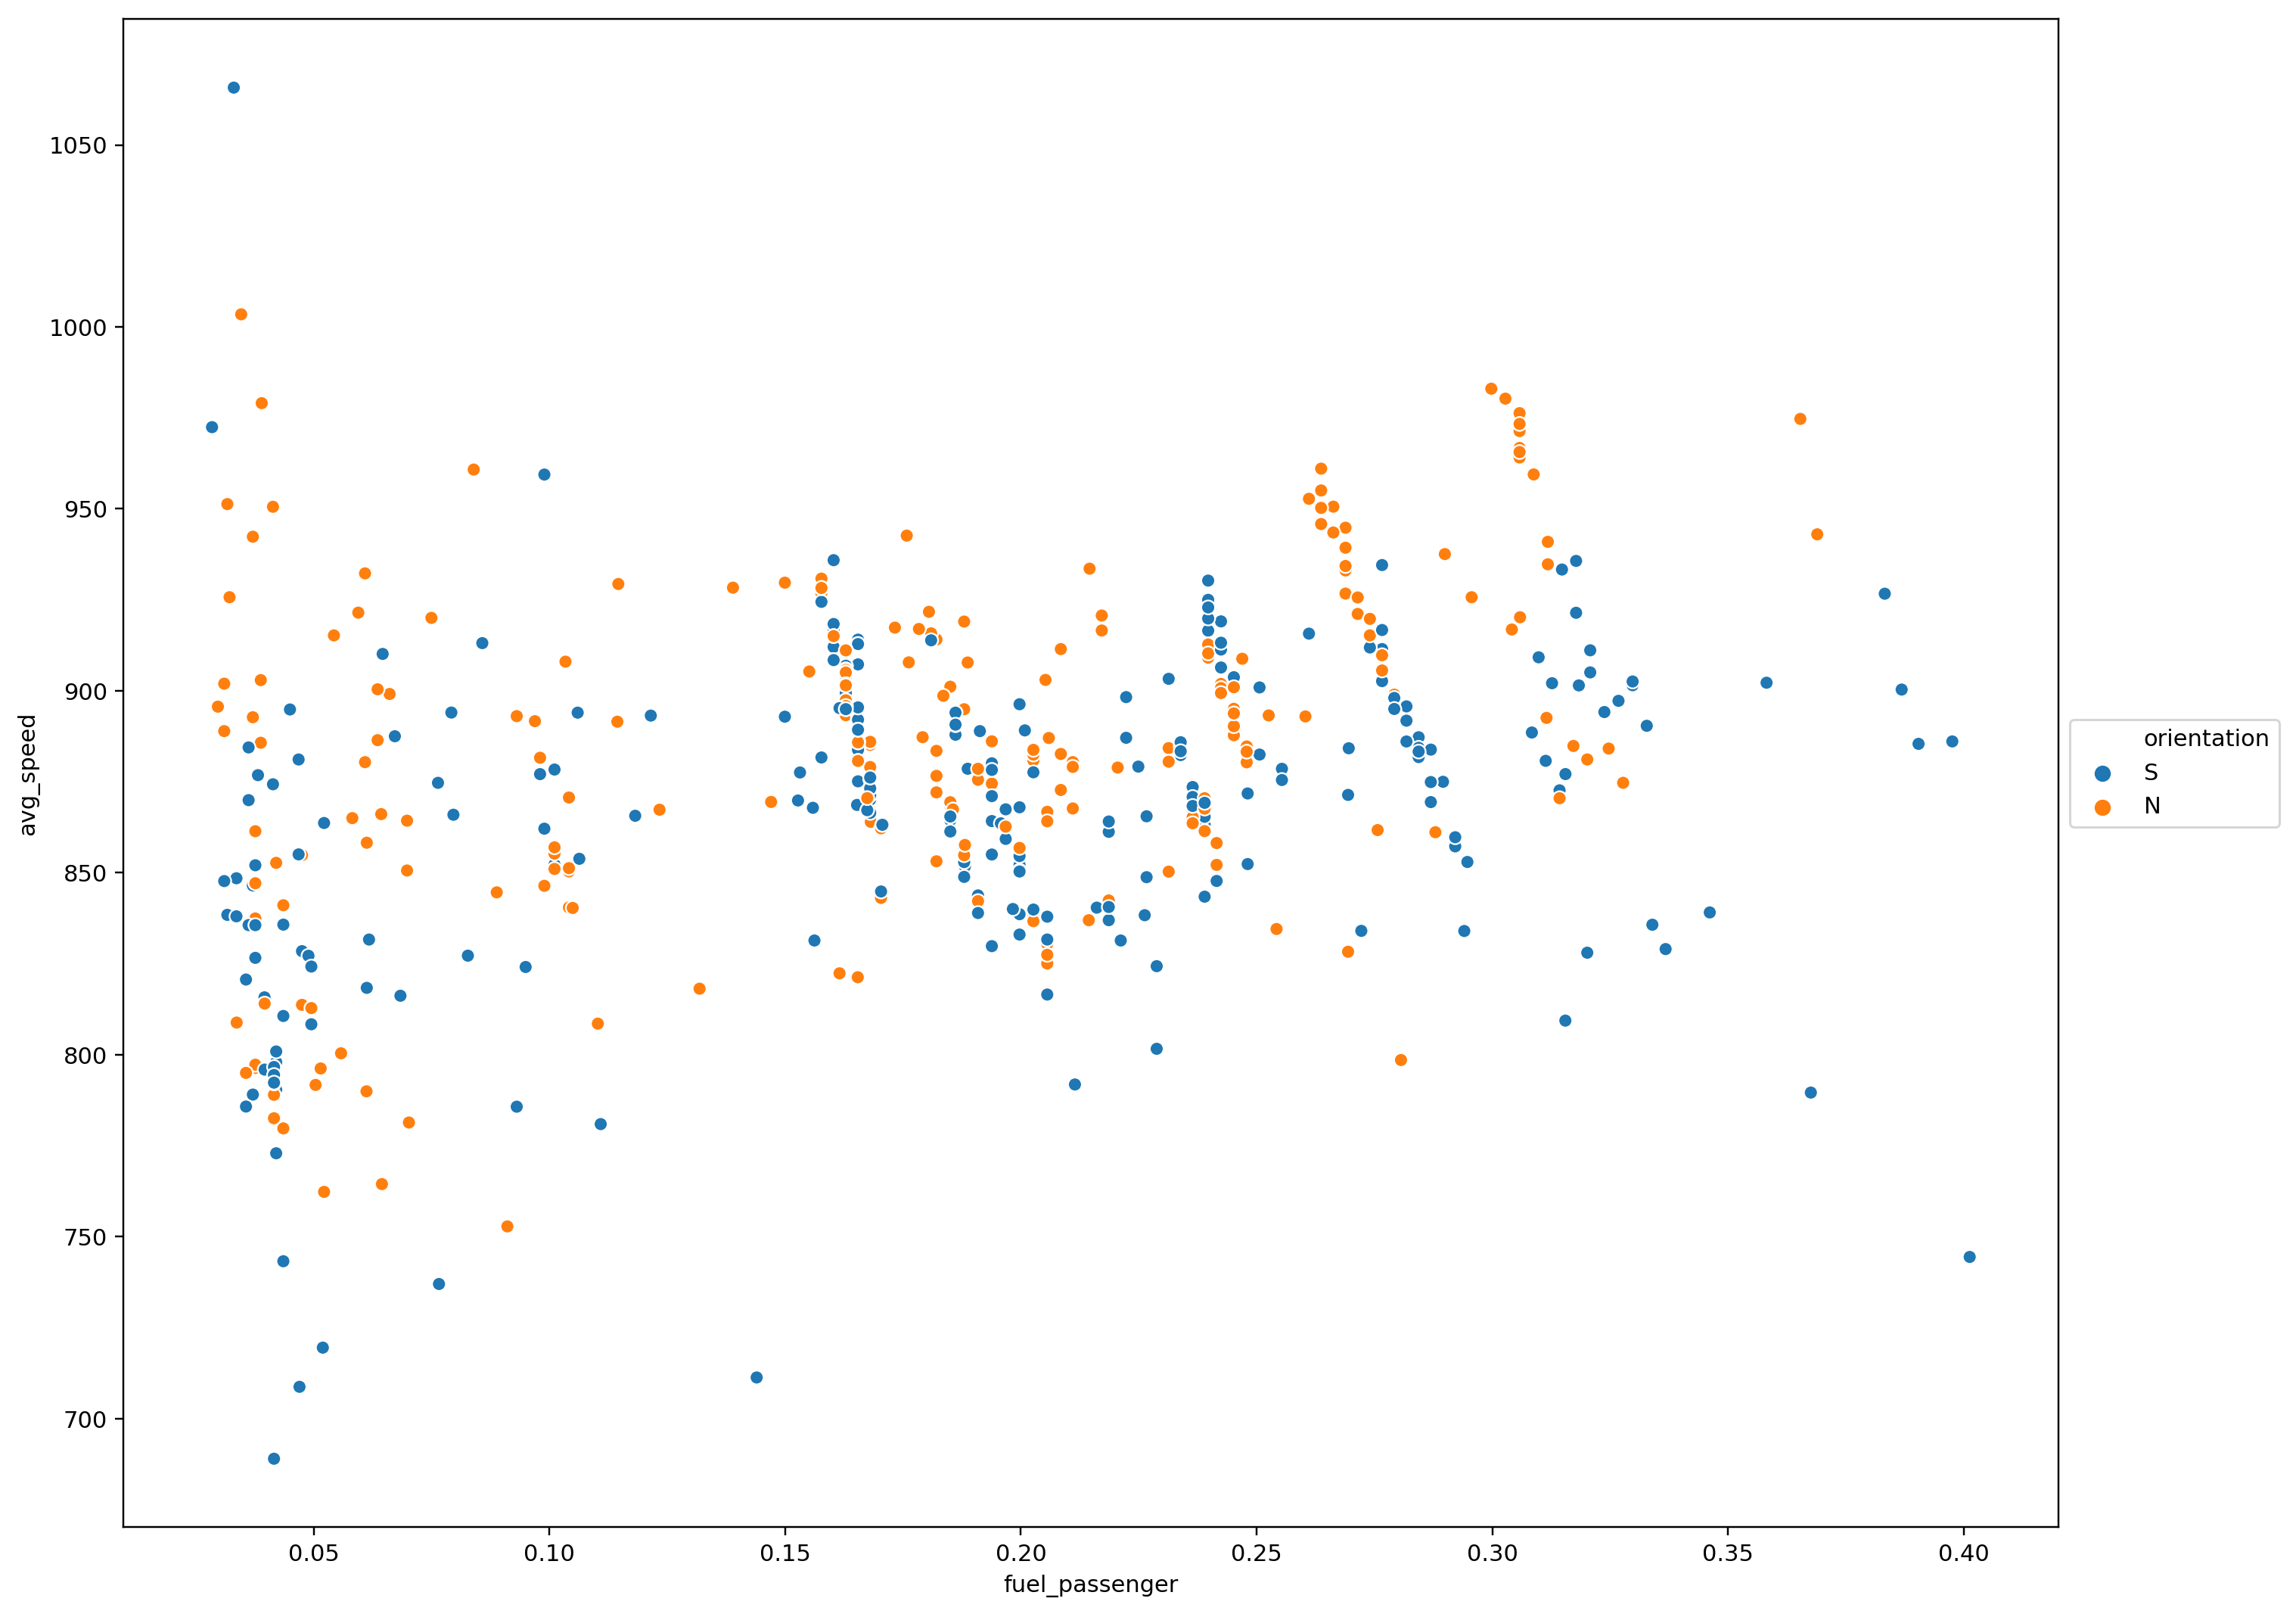

In [23]:
plt.figure(num=None, figsize=(15, 12), dpi=220, facecolor='w', edgecolor='k')

sns.scatterplot(x="fuel_passenger", y="avg_speed", hue="orientation", data=fl2)


plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)) # Putting the legend box to the right side of the plot.

plt.show()

Even though is noticeable the significantly lesser number of flights of the N and S groups, they show no clear difference in distribution as the [E,W] show.

The smaller sample of the [N,S] group should not hurt the analysis, as thsis is just the control group, while our main focus is on the difference inside the [E,W] group.

### T-Test for Two Independent Samples:

To compare the mean of two independent groups we will use the T-Test for Two Independent Samples, which is a two-sided test for the null hypothesis that 2 independent samples have identical expected values (means).

First we will create variables to hold the fuel consumption by passenger and average speed for each group of cardinal direction:

In [24]:
f_E = fl[fl.orientation == "E"]["fuel_passenger"]
f_W = fl[fl.orientation == "W"]["fuel_passenger"]
f_N = fl[fl.orientation == "N"]["fuel_passenger"]
f_S = fl[fl.orientation == "S"]["fuel_passenger"]

s_E = fl[fl.orientation == "E"]["avg_speed"]
s_W = fl[fl.orientation == "W"]["avg_speed"]
s_N = fl[fl.orientation == "N"]["avg_speed"]
s_S = fl[fl.orientation == "S"]["avg_speed"]

#### We can now execute the test for the fuel_passenger attribute:

In [25]:
sp.stats.ttest_ind(f_E, f_W) # E and W - Fuel by Passenger

Ttest_indResult(statistic=-8.064630879533736, pvalue=1.2762302574416608e-15)

In [26]:
sp.stats.ttest_ind(f_N, f_S) # N and S - Fuel by Passenger

Ttest_indResult(statistic=-0.8189004525720727, pvalue=0.41317052377078556)

The null hypothesis of identical means is thoroughly rejected in the [E,W] group (p-value = 1.4e-15), while not rejected in the [N,S] group (p-group = 0.41).

These results are supporting our claim of Jet Stream impact on fuel usage, as the fuel usage of flights going East are significantly different in expected value from the ones going West while the ones going South and North show no significant difference in consumption.


#### Now for the avg_speed attribute:

In [27]:
sp.stats.ttest_ind(s_E, s_W) # E and W - Average Speed

Ttest_indResult(statistic=51.076835893912914, pvalue=0.0)

In [28]:
sp.stats.ttest_ind(s_N, s_S) # N and S - Average Speed

Ttest_indResult(statistic=4.635702928066789, pvalue=4.3735573492609794e-06)

The test for different means in Average Cruising Speed of flights going East and West presented such a high test statistic (51.1) that the algorithm showed zero as the p-value (which is just really low). In this case the test also did reject the null hypothesis for the [N,S] group, even though it resulted in a significantly smaller statistic test (4.4) than the [E,W] group.

We could conclude with these informations that there is, indeed, a statistically significant difference in the Fuel Consumed by Passenger and Average Speed between flights going East and West, while the flights going South and North showed significant difference only in Average Speed.

We should try to group the flights by size of airplane and then apply the T-Test again, since this could be impacting the results. For this, we should use K-Means method to find those groups (clusters).

### Clusterizing the Flights in Airplane Sizes using K-Means:

First,we need to choose relevan varaibles to be used as input in the K-Means algorithm.

Numbers of Passengers, Consumption and Average Speed come to mind when talking about size of airplanes.

But, naturally, the variables Consumption and Passengers are so correlated that there is no need to use both:

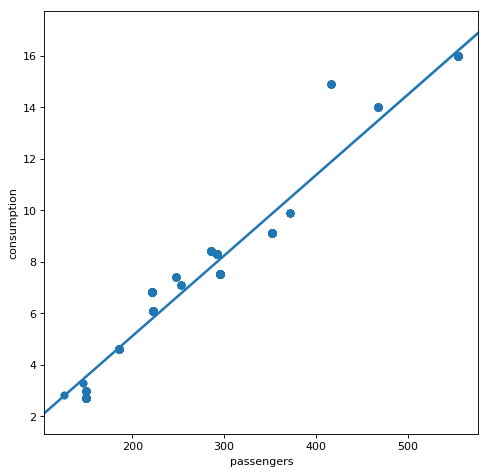

In [29]:
plt.figure(num=None, figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
sns.regplot(x="passengers", y="consumption", data=fl)
plt.show()

Now, before we can use avg_speed and passengers as input, we need to scale them. We will use the Min Max scaling:

In [30]:
# Function to minmax scaling a vector.
def minmax_s(x):
    mn, mx = x.min(), x.max()
    return (x - mn) / (mx - mn)

avg_speed and passengers attributes of the fl table are chosen as input to the K-Means algorithm. Then we apply the scaling:

In [31]:
d = fl[["avg_speed", "passengers"]]

for c in d.columns:
    d[c] = minmax_s(d[c])  

C:\Users\maxde\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


#### K-Means with 3 Clusters:

We want so separate the dataset in 3 clusters: Small, Medium and Big airplanes:

In [59]:
kmeans = KMeans(n_clusters=3, max_iter=300, random_state=12345) # Set the number of clusters we want, the maximum number
                                                            # of iteration and a seed for the random state.
kmeans.fit(d)
y_kmeans = kmeans.predict(d)

#### Plotting the resulting clusters:

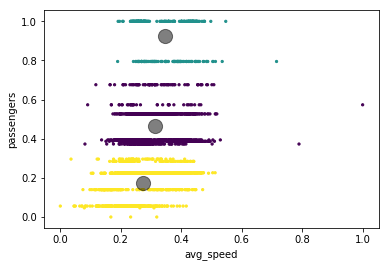

In [60]:
x = 0 # Select the variable that goes into the X axis in the graph.
y = 1 # Select the variable that goes into the Y axis in the graph.
plt.scatter(d.iloc[:, x], d.iloc[:, y], c=y_kmeans, s=5, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, x], centers[:, y], c='black', s=200, alpha=0.5);
plt.xlabel(d.columns[x], fontsize=10)
plt.ylabel(d.columns[y], fontsize=10)
plt.show()

The K-Means apparently clustered these points mainly based on number of passengers.

Lets turn the resulting vector of clusters in a categorical variable:

In [34]:
y_kmeans = pd.Series(y_kmeans)

y_kmeans = pd.Categorical(y_kmeans)

y_kmeans.categories = ["Medium", "Big", "Small"]

y_kmeans


[Small, Medium, Small, Medium, Medium, ..., Medium, Medium, Small, Big, Big]
Length: 2530
Categories (3, object): [Medium, Big, Small]

Add the variable to fl table:

In [35]:
fl["kmeans"] = y_kmeans
fl.head()

,ap_orig,dir_orig,ap_dest,dir_dest,dist,avg_speed,time,plane_reg,plane_model,time_orig,time_dest,hex_id,orientation,consumption,passengers,fuel_passenger,kmeans
0,SEA,180,IAD,,3392.009,975.494,3.5,N17128,Boeing 757-224ER,2018-10-31 20:30:23,2018-10-31 23:59:01,/1e680781,E,4.6,186,0.086559,Small
1,LIS,206,REC,,2271.824,874.713,2.6,9H-SOL,Airbus A340-313,2018-10-31 20:30:22,2018-10-31 23:06:12,/1e6812e7,S,8.4,286,0.076364,Medium
2,EWR,207,LIM,,3691.428,853.839,4.3,N33132,Boeing 757-224,2018-10-31 19:40:08,2018-10-31 23:59:32,/1e67e78f,S,4.6,186,0.106344,Small
3,ADD,74,FRA,,1484.959,800.397,1.9,D-AIGZ,Airbus A340-313,2018-10-31 22:08:28,2018-10-31 23:59:47,/1e6822d5,N,8.4,286,0.055804,Medium
4,JNB,15,DXB,,2658.146,920.039,2.9,A6-EGU,Boeing 777-31H(ER),2018-10-31 21:05:21,2018-10-31 23:58:42,/1e681a96,N,9.1,352,0.074972,Medium


As expected, the clusters separate well the number of passengers:

In [36]:
fl.groupby("kmeans")["passengers"].mean()

kmeans
Medium    324.468580
Big       522.323529
Small     201.015480
Name: passengers, dtype: float64

As well as the average speed, with bigger planes flying faster than the smaller ones:

In [37]:
fl.groupby("kmeans")["avg_speed"].mean()

kmeans
Medium    902.255284
Big       930.518893
Small     864.754615
Name: avg_speed, dtype: float64

### Reapply T-Test for Two Independent Samples based on Clusters:

Let us now separate the groups based on the three clusters and see if the results show something different.

First, we need to separate the groups:

In [38]:
f_E = fl[fl.orientation == "E"]
f_W = fl[fl.orientation == "W"]
f_N = fl[fl.orientation == "N"]
f_S = fl[fl.orientation == "S"]

And then separate into the clusters inside of each cardinal direction group:

In [39]:
f_E1 = f_E[f_E.kmeans=="Small"]
f_E2 = f_E[f_E.kmeans=="Medium"]
f_E3 = f_E[f_E.kmeans=="Big"]

f_W1 = f_W[f_W.kmeans=="Small"]
f_W2 = f_W[f_W.kmeans=="Medium"]
f_W3 = f_W[f_W.kmeans=="Big"]

f_N1 = f_N[f_N.kmeans=="Small"]
f_N2 = f_N[f_N.kmeans=="Medium"]
f_N3 = f_N[f_N.kmeans=="Big"]

f_S1 = f_S[f_S.kmeans=="Small"]
f_S2 = f_S[f_S.kmeans=="Medium"]
f_S3 = f_S[f_S.kmeans=="Big"]

#### T-Test for 2 Ind. Samples - E and W - Fuel by Passenger:

In [40]:
sp.stats.ttest_ind(f_E1.fuel_passenger, f_W1.fuel_passenger) # E and W - Small - Fuel by Passenger

Ttest_indResult(statistic=-4.142307804346908, pvalue=3.7980558944034434e-05)

In [41]:
sp.stats.ttest_ind(f_E2.fuel_passenger, f_W2.fuel_passenger) # E and W - Medium - Fuel by Passenger

Ttest_indResult(statistic=-8.23005646090517, pvalue=6.813729629597409e-16)

In [42]:
sp.stats.ttest_ind(f_E3.fuel_passenger, f_W3.fuel_passenger) # E and W - Big - Fuel by Passenger

Ttest_indResult(statistic=-3.7305628796938706, pvalue=0.00023766269742801817)

All clusters still rejecting the null hypothesis of equal means.

#### T-Test for 2 Ind. Samples - N and S - Fuel by Passenger:

In [43]:
sp.stats.ttest_ind(f_N1.fuel_passenger, f_S1.fuel_passenger) # N and S - Small - Fuel by Passenger

Ttest_indResult(statistic=0.06072045902572852, pvalue=0.9516616020111731)

In [44]:
sp.stats.ttest_ind(f_N2.fuel_passenger, f_S2.fuel_passenger) # N and S - Medium - Fuel by Passenger

Ttest_indResult(statistic=-1.4000466217943612, pvalue=0.16224469284531487)

In [45]:
sp.stats.ttest_ind(f_N3.fuel_passenger, f_S3.fuel_passenger) # N and S - Big - Fuel by Passenger

Ttest_indResult(statistic=-0.08512145711022466, pvalue=0.9328709456289426)

The p-value is still extremely high for all clusters, which indicates we should not reject the null hypothesis.

#### T-Test for 2 Ind. Samples - E and W - Average Speed:

In [46]:
sp.stats.ttest_ind(f_E1.avg_speed, f_W1.avg_speed) # E and W - Small - Average Speed

Ttest_indResult(statistic=28.84065879907573, pvalue=1.5771904785859285e-126)

In [47]:
sp.stats.ttest_ind(f_E2.avg_speed, f_W2.avg_speed) # E and W - Small - Average Speed

Ttest_indResult(statistic=45.70465544118356, pvalue=2.3356481366211e-233)

In [48]:
sp.stats.ttest_ind(f_E3.avg_speed, f_W3.avg_speed) # E and W - Small - Average Speed

Ttest_indResult(statistic=25.78491191988461, pvalue=1.2585365389171115e-71)

Same happens here. Extremely small p-values rejecting the null hypothesis for each and every cluster.

#### T-Test for 2 Ind. Samples - N and S - Average Speed:

In [49]:
sp.stats.ttest_ind(f_N1.avg_speed, f_S1.avg_speed) # N and S - Small - Average Speed

Ttest_indResult(statistic=2.7076278497704735, pvalue=0.0075529829752876655)

In [50]:
sp.stats.ttest_ind(f_N2.avg_speed, f_S2.avg_speed) # N and S - Small - Average Speed

Ttest_indResult(statistic=3.6041634704952656, pvalue=0.0003510982761824646)

In [51]:
sp.stats.ttest_ind(f_N3.avg_speed, f_S3.avg_speed) # N and S - Small - Average Speed

Ttest_indResult(statistic=7.404419454190563, pvalue=1.206824183195169e-07)

Again, the clusterization does not seem to change our previous results. The null hypothesis of equal mean average speed for N and S is rejected for all three clusters.

We can, therefore, come to the conclusion that the size of the airplane does not interfere in the analysis we are making. That is, our previous obtained results are valid.

As it is, our claim that the Jet Streams can and do affect the fuel consumption and average cruising speed of commercial flights stands true.

# END